# StyleGAN

In [248]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [249]:
def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):
    '''
    Function for visualizing images: Given a tensor of images, number of images,
    size per image, and images per row, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu().clamp_(0, 1)
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow, padding=0)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.axis('off')
    plt.show()

## 1. Mapping Network

In [250]:
class MappingLayers(nn.Module):
    
    '''
    Mapping Layers Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        hidden_dim: the inner dimension, a scalar
        w_dim: the dimension of the intermediate noise vector, a scalar
    '''
 
    def __init__(self, z_dim, hidden_dim, w_dim):
        super().__init__()
        self.mapping = nn.Sequential(
            # Please write a neural network which takes in tensors of 
            # shape (n_samples, z_dim) and outputs (n_samples, w_dim)
            # with a hidden layer with hidden_dim neurons
            #### START CODE HERE ####
            nn.Linear(z_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, w_dim)
            #### END CODE HERE ####
        )

    def forward(self, noise):
        '''
        Function for completing a forward pass of MappingLayers: 
        Given an initial noise tensor, returns the intermediate noise tensor.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.mapping(noise)
    
    #UNIT TEST COMMENT: Required for grading
    def get_mapping(self):
        return self.mapping

## 2. Truncation trick

In [234]:
from scipy.stats import truncnorm
def get_truncated_noise(n_samples, z_dim, truncation):
    '''
    Function for creating truncated noise vectors: Given the dimensions (n_samples, z_dim)
    and truncation value, creates a tensor of that shape filled with random
    numbers from the truncated normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        truncation: the truncation value, a non-negative scalar
    '''
    #### START CODE HERE ####
    truncated_noise = truncnorm.rvs(-1*truncation, truncation, size=(n_samples, z_dim))
    #### END CODE HERE ####
    return torch.Tensor(truncated_noise)

## 3. Injection Noise

In [244]:
class InjectNoise(nn.Module):
    '''
    Inject Noise Class
    Values:
        channels: the number of channels the image has, a scalar
    '''
    def __init__(self, channels):
        
        super().__init__()
        self.weight = nn.Parameter( # You use nn.Parameter so that these weights can be optimized
            # Initiate the weights for the channels from a random normal distribution
            #### START CODE HERE ####
            torch.randn(channels)[None, :, None, None] #torch.randn((1,channels,1,1))
            #### END CODE HERE ####
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of InjectNoise: Given an image, 
        returns the image with random noise added.
        Parameters:
            image: the feature map of shape (n_samples, channels, width, height)
        '''
        # Set the appropriate shape for the noise!
        
        #### START CODE HERE ####
        noise_shape = (image.shape[0], 1, image.shape[2], image.shape[3])
        #### END CODE HERE ####
        
        noise = torch.randn(noise_shape, device=image.device) # Creates the random noise
        return image + self.weight * noise # Applies to image after multiplying by the weight for each channel
    
    #UNIT TEST COMMENT: Required for grading
    def get_weight(self):
        return self.weight
    
    #UNIT TEST COMMENT: Required for grading
    def get_self(self):
        return self
    

## 4. Adaptive Normalization

In [237]:
class AdaIN(nn.Module):
    '''
    AdaIN Class
    Values:
        channels: the number of channels the image has, a scalar
        w_dim: the dimension of the intermediate noise vector, a scalar
    '''

    def __init__(self, channels, w_dim):
        super().__init__()

        # Normalize the input per-dimension
        self.instance_norm = nn.InstanceNorm2d(channels)

        # You want to map w to a set of style weights per channel.
        # Replace the Nones with the correct dimensions - keep in mind that 
        # both linear maps transform a w vector into style weights 
        # corresponding to the number of image channels.
        #### START CODE HERE ####
        self.style_scale_transform = nn.Linear(w_dim, channels)
        self.style_shift_transform = nn.Linear(w_dim, channels)
        #### END CODE HERE ####

    def forward(self, image, w):
        '''
        Function for completing a forward pass of AdaIN: Given an image and intermediate noise vector w, 
        returns the normalized image that has been scaled and shifted by the style.
        Parameters:
            image: the feature map of shape (n_samples, channels, width, height)
            w: the intermediate noise vector
        '''
        normalized_image = self.instance_norm(image)
        style_scale = self.style_scale_transform(w)[:, :, None, None]
        style_shift = self.style_shift_transform(w)[:, :, None, None]
        
        # Calculate the transformed image
        #### START CODE HERE ####
        transformed_image = style_scale * normalized_image + style_shift
        #### END CODE HERE ####
        return transformed_image
    
    #UNIT TEST COMMENT: Required for grading
    def get_style_scale_transform(self):
        return self.style_scale_transform
    
    #UNIT TEST COMMENT: Required for grading
    def get_style_shift_transform(self):
        return self.style_shift_transform
    
    #UNIT TEST COMMENT: Required for grading
    def get_self(self):
        return self 

## 5. Progressive GAN

In [251]:
# UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED CELL: MicroStyleGANGeneratorBlock

class MicroStyleGANGeneratorBlock(nn.Module):
    '''
    Micro StyleGAN Generator Block Class
    Values:
        in_chan: the number of channels in the input, a scalar
        out_chan: the number of channels wanted in the output, a scalar
        w_dim: the dimension of the intermediate noise vector, a scalar
        kernel_size: the size of the convolving kernel
        starting_size: the size of the starting image
    '''

    def __init__(self, in_chan, out_chan, w_dim, kernel_size, starting_size, use_upsample=True):
        super().__init__()
        self.use_upsample = use_upsample
        # Replace the Nones in order to:
        # 1. Upsample to the starting_size, bilinearly (https://pytorch.org/docs/master/generated/torch.nn.Upsample.html)
        # 2. Create a kernel_size convolution which takes in 
        #    an image with in_chan and outputs one with out_chan (https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
        # 3. Create an object to inject noise
        # 4. Create an AdaIN object
        # 5. Create a LeakyReLU activation with slope 0.2
        
        #### START CODE HERE ####
        if self.use_upsample:
            self.upsample = nn.Upsample((starting_size), mode='bilinear')
        self.conv = nn.Conv2d(in_chan, out_chan, kernel_size, padding=1) # Padding is used to maintain the image size
        self.inject_noise = InjectNoise(out_chan)
        self.adain = AdaIN(out_chan, w_dim)
        self.activation = nn.LeakyReLU(0.2)
        #### END CODE HERE ####

    def forward(self, x, w):
        '''
        Function for completing a forward pass of MicroStyleGANGeneratorBlock: Given an x and w, 
        computes a StyleGAN generator block.
        Parameters:
            x: the input into the generator, feature map of shape (n_samples, channels, width, height)
            w: the intermediate noise vector
        '''
        if self.use_upsample:
            x = self.upsample(x)
        x = self.conv(x)
        x = self.inject_noise(x)
        x = self.activation(x)
        x = self.adain(x, w)
        return x
    
    #UNIT TEST COMMENT: Required for grading
    def get_self(self):
        return self;

In [252]:
class MicroStyleGANGenerator(nn.Module):
    '''
    Micro StyleGAN Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        map_hidden_dim: the mapping inner dimension, a scalar
        w_dim: the dimension of the intermediate noise vector, a scalar
        in_chan: the dimension of the constant input, usually w_dim, a scalar
        out_chan: the number of channels wanted in the output, a scalar
        kernel_size: the size of the convolving kernel
        hidden_chan: the inner dimension, a scalar
    '''

    def __init__(self, 
                 z_dim, 
                 map_hidden_dim,
                 w_dim,
                 in_chan,
                 out_chan, 
                 kernel_size, 
                 hidden_chan):
        super().__init__()
        self.map = MappingLayers(z_dim, map_hidden_dim, w_dim)
        # Typically this constant is initiated to all ones, but you will initiate to a
        # Gaussian to better visualize the network's effect
        self.starting_constant = nn.Parameter(torch.randn(1, in_chan, 4, 4))
        
        self.block0 = MicroStyleGANGeneratorBlock(in_chan, hidden_chan, w_dim, kernel_size, 4, use_upsample=False)
        
        self.block1 = MicroStyleGANGeneratorBlock(hidden_chan, hidden_chan, w_dim, kernel_size, 8)
        
        self.block2 = MicroStyleGANGeneratorBlock(hidden_chan, hidden_chan, w_dim, kernel_size, 16)
        
        # You need to have a way of mapping from the output noise to an image, 
        # so you learn a 1x1 convolution to transform the e.g. 512 channels into 3 channels
        # (Note that this is simplified, with clipping used in the real StyleGAN)
        
        self.block1_to_image = nn.Conv2d(hidden_chan, out_chan, kernel_size=1)
        self.block2_to_image = nn.Conv2d(hidden_chan, out_chan, kernel_size=1)
        self.alpha = 0.2

    def upsample_to_match_size(self, smaller_image, bigger_image):
        '''
        Function for upsampling an image to the size of another: Given a two images (smaller and bigger), 
        upsamples the first to have the same dimensions as the second.
        Parameters:
            smaller_image: the smaller image to upsample
            bigger_image: the bigger image whose dimensions will be upsampled to
        '''
        return F.interpolate(smaller_image, size=bigger_image.shape[-2:], mode='bilinear')

    def forward(self, noise, return_intermediate=False):
        '''
        Function for completing a forward pass of MicroStyleGANGenerator: Given noise, 
        computes a StyleGAN iteration.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
            return_intermediate: a boolean, true to return the images as well (for testing) and false otherwise
        '''
        x = self.starting_constant
        
        w = self.map(noise)
        
        x = self.block0(x, w)
        
        x_small = self.block1(x, w) # First generator run output
        
        x_small_image = self.block1_to_image(x_small)
        
        x_big = self.block2(x_small, w) # Second generator run output 
        x_big_image = self.block2_to_image(x_big)
        
        x_small_upsample = self.upsample_to_match_size(x_small_image, x_big_image) # Upsample first generator run output to be same size as second generator run output 
        # Interpolate between the upsampled image and the image from the generator using alpha
        
        #### START CODE HERE ####
        interpolation = self.alpha * (x_big_image) + (1-self.alpha) * (x_small_upsample)
        #### END CODE HERE #### 
        
        if return_intermediate:
            return interpolation, x_small_upsample, x_big_image
        return interpolation
    
    #UNIT TEST COMMENT: Required for grading
    def get_self(self):
        return self;

## 6. Train

In [245]:
z_dim = 128
out_chan = 3
truncation = 0.7

mu_stylegan = MicroStyleGANGenerator(
    z_dim=z_dim, 
    map_hidden_dim=1024,
    w_dim=496,
    in_chan=512,
    out_chan=out_chan, 
    kernel_size=3, 
    hidden_chan=256
)

test_samples = 10
test_result = mu_stylegan(get_truncated_noise(test_samples, z_dim, truncation))

# Check if the block works
assert tuple(test_result.shape) == (test_samples, out_chan, 16, 16)

# Check that the interpolation is correct
mu_stylegan.alpha = 1.
test_result, _, test_big =  mu_stylegan(
    get_truncated_noise(test_samples, z_dim, truncation), 
    return_intermediate=True)
assert torch.abs(test_result - test_big).mean() < 0.001
mu_stylegan.alpha = 0.
test_result, test_small, _ =  mu_stylegan(
    get_truncated_noise(test_samples, z_dim, truncation), 
    return_intermediate=True)
assert torch.abs(test_result - test_small).mean() < 0.001
print("Success!")

/Users/alexanderkolesov/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


Success!


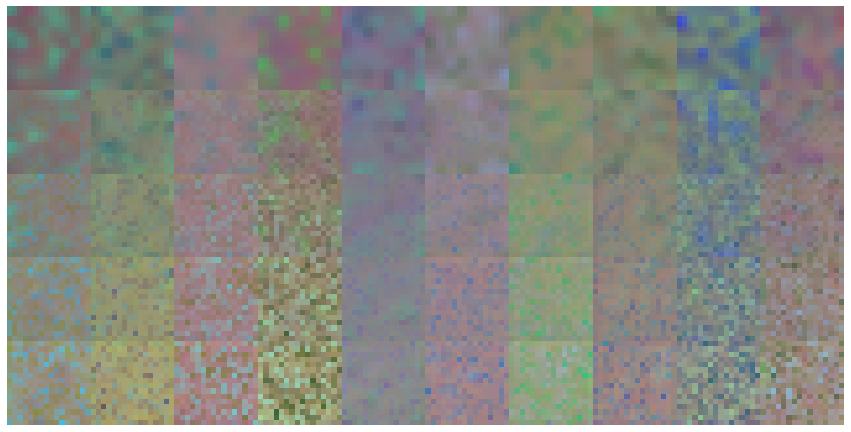

In [246]:
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]

viz_samples = 10
# The noise is exaggerated for visual effect
viz_noise = get_truncated_noise(viz_samples, z_dim, truncation) * 10

mu_stylegan.eval()
images = []
for alpha in np.linspace(0, 1, num=5):
    mu_stylegan.alpha = alpha
    viz_result, _, _ =  mu_stylegan(
        viz_noise, 
        return_intermediate=True)
    images += [tensor for tensor in viz_result]
show_tensor_images(torch.stack(images), nrow=viz_samples, num_images=len(images))
mu_stylegan = mu_stylegan.train()